In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
import scipy.io as sio

In [2]:
"""
data = sio.loadmat('mnist.mat')


Xtrain = data['trainX'][:10000,:].astype(int)
Xtest = data['testX'].astype(int)
ytrain =data['trainY'][0,:10000].astype(int)
ytest =  data['testY'][0,:].astype(int)

idx = np.logical_or(np.equal(ytrain,4), np.equal(ytrain,9))
Xtrain = Xtrain[idx,:]
ytrain = ytrain[idx]
ytrain[np.equal(ytrain,4)] = 1
ytrain[np.equal(ytrain,9)] = -1

idx = np.logical_or(np.equal(ytest,4), np.equal(ytest,9))
Xtest = Xtest[idx,:]
ytest = ytest[idx]
ytest[np.equal(ytest,4)] = 1
ytest[np.equal(ytest,9)] = -1


sio.savemat('mnist_binary_small.mat',{'Xtrain':Xtrain,'ytrain':ytrain,'Xtest':Xtest,'ytest':ytest})
"""

data = sio.loadmat('mnist_binary_small.mat')
Xtrain = data['Xtrain']
Xtest = data['Xtest']
ytrain = data['ytrain'][0,:]
ytest = data['ytest'][0,:]

print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)


(1958, 784) (1991, 784) (1958,) (1991,)


In [3]:
def get_weighted_misclass(w,y,yhat):
    return (np.sum(w * (np.not_equal(y, yhat)).astype(int)))

def get_misclass(y,yhat):
    return np.sum((np.not_equal(y, yhat)).astype(int))/len(y)

def get_exp_loss(y,yhat):
    return np.sum((np.exp(-1*y*yhat)))/len(y)

clf = tree.DecisionTreeClassifier(max_depth=1)
weightTrain = np.full(len(ytrain), 1/len(ytrain))
weightTest = np.full(len(ytest), 1/len(ytest))

model = clf.fit(Xtrain, ytrain, weightTrain)

ypredTrain = model.predict(Xtrain)
ypredTest = model.predict(Xtest)

print("train misclassification:", get_weighted_misclass(weightTrain,ytrain,ypredTrain))
print("test misclasisification:",get_weighted_misclass(weightTest,ytest,ypredTest))
print("exponential loss:",get_exp_loss(ytrain, ypredTrain))


train misclassification: 0.109805924412666
test misclasisification: 0.15268709191361124
exponential loss: 0.6259675480492947


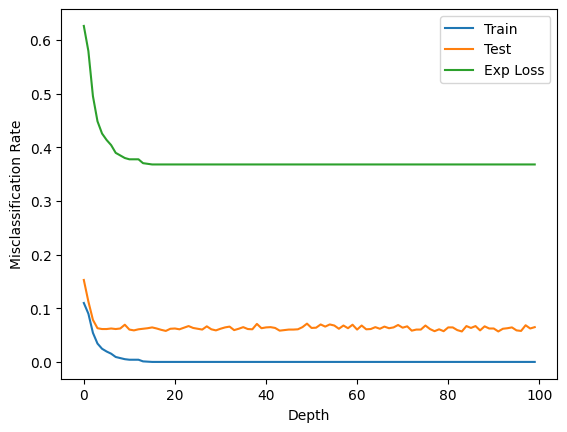

smallest train misclassification rate: 0.0
smallest test misclassification rate: 0.05675539929683576
smallest train exponential loss: 0.3678794411714424


In [4]:
#deep trees
train_misclass_rate = []
test_misclass_rate = []
train_exponential_loss = []

for i in range(100):
    clf = tree.DecisionTreeClassifier(max_depth=i+1)
    weightTrain = np.full(len(ytrain), 1/len(ytrain))
    weightTest = np.full(len(ytest), 1/len(ytest))
    model = clf.fit(Xtrain, ytrain, weightTrain)
    
    ypredTrain = model.predict(Xtrain)
    ypredTest = model.predict(Xtest)
    
    train_misclass_rate.append(get_misclass(ytrain, ypredTrain))
    test_misclass_rate.append(get_misclass(ytest, ypredTest))
    
    train_exponential_loss.append(get_exp_loss(ytrain, ypredTrain))
    

plt.plot(range(100), train_misclass_rate, label='Train')
plt.plot(range(100), test_misclass_rate, label='Test')
plt.plot(range(100), train_exponential_loss, label="Exp Loss")
plt.xlabel('Depth')
plt.ylabel('Misclassification Rate')
plt.legend()
plt.show()

print("smallest train misclassification rate:", min(train_misclass_rate))
print("smallest test misclassification rate:", min(test_misclass_rate))
print("smallest train exponential loss:", min(train_exponential_loss))

In [5]:
#boosted decision stumps

stump = tree.DecisionTreeClassifier(max_depth=1)
weight = np.full(len(ytrain), 1/len(ytrain))
stumpModel = stump.fit(Xtrain, ytrain, weight)
ypred = stumpModel.predict(Xtrain)

epsilon = get_weighted_misclass(weight, ytrain, ypred)
alpha = 0.5 * np.log10((1 - epsilon) / epsilon)

w = weight*((np.exp(-1*alpha*ytrain*ypred)))
w = w/np.sum(w)

clf = stumpModel.fit(Xtrain, ytrain, sample_weight = w)

smallest train misclassification rate: 0.10980592441266598
smallest test misclassification rate: 0.15268709191361124
smallest train exponential loss: 0.6259675480492947


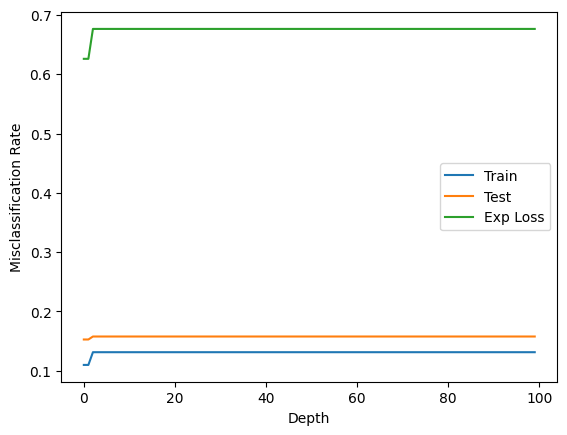

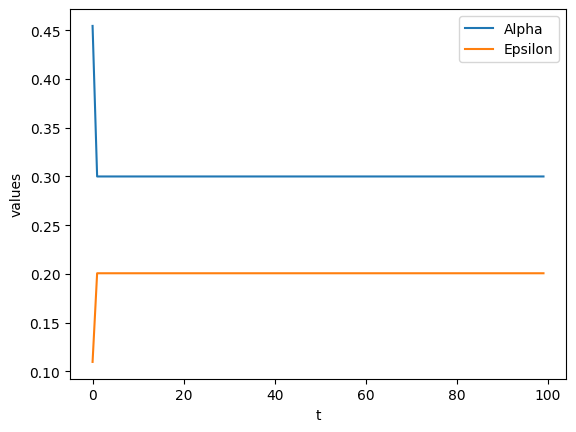

In [6]:
#adaboost method
#boy did i do this wrong

train_exponential_loss = []
train_misclass_rate = []
test_misclass_rate = []
weakClassifiers = []
epsilonList = []
alphaList = []

trainPreds=[]
testPreds=[]

for i in range(100):
    if i > 0:
        weight = np.full(len(ytrain), 1/len(ytrain))
        weight = weight*((np.exp(-1*alpha*ytrain*ypred)))
        weight = w/np.sum(w)
    else:   
        weight = np.full(len(ytrain), 1/len(ytrain))
    
    stump = tree.DecisionTreeClassifier(max_depth = 1)
    stumpModel = stump.fit(Xtrain, ytrain, sample_weight = weight)
    ypred = stumpModel.predict(Xtrain)
    weakClassifiers.append(stump)
        
    epsilon = get_weighted_misclass(weight, ytrain, ypred)
    epsilonList.append(epsilon)
    alpha = alpha = 0.5 * np.log10((1 - epsilon) / epsilon)
    alphaList.append(alpha)


for i in range(len(weakClassifiers)):
    trainPreds.append(alphaList[i] * weakClassifiers[i].predict(Xtrain))
    testPreds.append(alphaList[i]*weakClassifiers[i].predict(Xtest))
    
    ypredTrain = np.sign(np.sum(trainPreds, axis=0))
    ypredTest = np.sign(np.sum(testPreds, axis=0))
    
    train_exponential_loss.append(get_exp_loss(ytrain,ypredTrain))
    train_misclass_rate.append(get_misclass(ytrain,ypredTrain))
    test_misclass_rate.append(get_misclass(ytest,ypredTest))
    
print("smallest train misclassification rate:", min(train_misclass_rate))
print("smallest test misclassification rate:", min(test_misclass_rate))
print("smallest train exponential loss:", min(train_exponential_loss))

plt.plot(range(100), train_misclass_rate, label='Train')
plt.plot(range(100), test_misclass_rate, label='Test')
plt.plot(range(100), train_exponential_loss, label="Exp Loss")
plt.xlabel('Depth')
plt.ylabel('Misclassification Rate')
plt.legend()
plt.show()

plt.plot(range(100), alphaList, label = 'Alpha')
plt.plot(range(100), epsilonList, label = 'Epsilon')
plt.xlabel('t')
plt.ylabel('values')
plt.legend()
plt.show()